In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.detection as afw_detect
import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
import lsst.afw.math as afw_math

In [2]:
def plot_serial(image, row, drow=1, x_range=None, label=None):
    """Plot a profile slice of the image data in the serial direction."""
    imarray = image.getArray()
    ny, nx = imarray.shape
    plt.errorbar(range(nx), np.sum(imarray[row:row + drow, :], axis=0), fmt='-',
                 label=label)
    if x_range is not None:
        axis = list(plt.axis())
        axis[:2] = x_range
        plt.axis(axis)
    plt.xlabel('x (pixel number)')
    plt.ylabel('pixel value (ADU)')

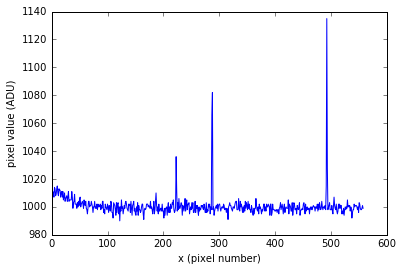

In [3]:
# These are Fe55 data from a recent delivery from ITL.
sensor_id = 'ITL-3800C-368'
image_file = '/nfs/farm/g/lsst/u1/jobHarness/jh_archive/ITL-CCD/ITL-3800C-368/6426/vendorIngest/v0/38604/fe55/20180108110712/ITL-3800C-368_fe55_fe55_001_20180108110712.fits'

# Read in the first image HDU as a Image of floats.
#hdu = 1         # v14_0
hdu = 2         # v12_0
image0 = afw_image.ImageF(image_file, hdu)

# Plot an arbitrary row of data.
row = 500
plot_serial(image0, row)

In [4]:
def get_bbox(md, keyword, dxmin=0, dymin=0, dxmax=0, dymax=0):
    """
    Parse an NOAO section keyword from the FITS header and return the 
    corresponding bounding box for sub-image retrieval.
    """
    xmin, xmax, ymin, ymax = [val - 1 for val in eval(md.get(keyword).replace(':', ','))]
    bbox = afw_geom.Box2I(afw_geom.Point2I(xmin + dxmin, ymin + dymin),
                          afw_geom.Point2I(xmax + dxmax, ymax + dymax))
    print("bounding box:", bbox)
    return bbox

In [5]:
# Statistics operations are performed on masked images.
#mask = afw_image.Mask(image0.getDimensions())    # v14_0
mask = afw_image.MaskU(image0.getDimensions())   # v12_0
mi0 = afw_image.MaskedImageF(image0, mask)

# An optional StatisticsControl object can be used to enable masks to
# omit pixel defects, bad columns, etc..
stat_ctrl = afw_math.StatisticsControl()
#mask_bits = 2**9 - 1      # enable the first 8 masks
#stat_ctrl.setAndMask(mask_bits)

# These are some of the statistics quantities that can be computed with makeStatistics(...).
flags = afw_math.MEDIAN | afw_math.MEAN | afw_math.MEANCLIP | afw_math.STDEV | afw_math.STDEVCLIP

# Read in the FITS header for this extension.
md = afw_image.readMetadata(image_file, hdu)

# Compute statistics for the imaging section.
print("Imaging section statistics:")
imsec = mi0.Factory(mi0, get_bbox(md, 'DATASEC'))
imstats = afw_math.makeStatistics(imsec, flags, stat_ctrl)
print("median:", imstats.getValue(afw_math.MEDIAN))
print("mean:", imstats.getValue(afw_math.MEAN))
print("meanclip:", imstats.getValue(afw_math.MEANCLIP))
print("stdev:", imstats.getValue(afw_math.STDEV))
print("stdevclip:", imstats.getValue(afw_math.STDEVCLIP), '\n')

# Compute statistics for the overscan region.
print("Overscan region statistics:")
oscan = mi0.Factory(mi0, get_bbox(md, 'BIASSEC', dxmin=5))   # skip the first 5 columns to avoid trailed charge.
ostats = afw_math.makeStatistics(oscan, flags, stat_ctrl)
print("median:", ostats.getValue(afw_math.MEDIAN))
print("mean:", ostats.getValue(afw_math.MEAN))
print("meanclip:", ostats.getValue(afw_math.MEANCLIP))
print("stdev:", ostats.getValue(afw_math.STDEV))
print("stdevclip:", ostats.getValue(afw_math.STDEVCLIP))

Imaging section statistics:
bounding box: Box2I((0, 0), (508, 1999))
median: 1000.0
mean: 1005.3007387
meanclip: 1000.03860837
stdev: 32.8393820948
stdevclip: 3.12040965028 

Overscan region statistics:
bounding box: Box2I((514, 0), (558, 1999))
median: 999.0
mean: 999.380611111
meanclip: 999.384535692
stdev: 2.68454915146
stdevclip: 2.65015649056


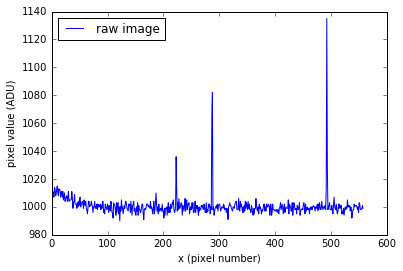

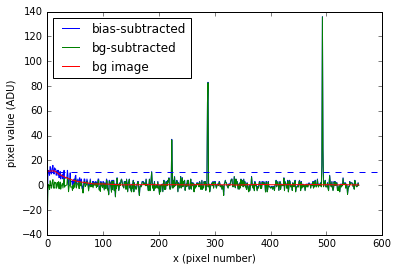

In [6]:
# Perform a bias level subtraction using the median of the overscan region.
bias_level = ostats.getValue(afw_math.MEDIAN)

plot_serial(image0, row, label='raw image')
plt.legend(loc=0)

# Make a deep copy since arthmetic operations modify the underlying pixel data in an Image.
#image_minus_bias = image0.Factory(image0, deep=True)    # v14_0
image_minus_bias = image0.Factory(image0)               # v12_0
image_minus_bias -= bias_level
plt.figure()
plot_serial(image_minus_bias, row, label='bias-subtracted')

# Compute a background image in bg_size x bg_size regions.
bg_size = 64
bg_ctrl = afw_math.BackgroundControl(bg_size, bg_size)
bg_obj = afw_math.makeBackground(image_minus_bias, bg_ctrl)
bg_image = bg_obj.getImageF('LINEAR')

#image = image0.Factory(image_minus_bias, deep=True)    # v14_0
image = image0.Factory(image_minus_bias)               # v12_0
image -= bg_image
plot_serial(image, row, label='bg-subtracted')
plot_serial(bg_image, row, label='bg image')

plt.legend(loc=0)

# Set a 4-sigma threshold for object detection.
threshold_value = 4.*ostats.getValue(afw_math.STDEVCLIP)
plt.axhline(threshold_value, linestyle='--')

In [7]:
# Detected objects are represented as pixel footprints above threshold.
threshold = afw_detect.Threshold(threshold_value)
npix_min = 5
fp_set = afw_detect.FootprintSet(image, threshold, npix_min)

# Grow the footprint by 1 pixel to avoid bias in the fluxes estimated
# by summing over pixel values.
grow = 1
isotropic = False
fp_set_grow = afw_detect.FootprintSet(fp_set, grow, isotropic)

In [8]:
def gain_est(hist, fe55_yield=1590.):
    """
    Estimate the system gain from the peak of the Fe55 flux
    distribution using the Fe55 yield at -100 C.
    """
    index = np.where(hist[0] == max(hist[0]))
    dn = hist[1][index][0]
    return fe55_yield/dn

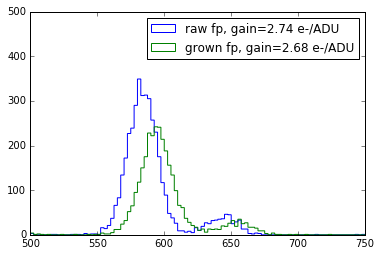

In [9]:
#mask = afw_image.Mask(image.getDimensions())    # v14_0
mask = afw_image.MaskU(image.getDimensions())   # v12_0
mi = afw_image.MaskedImageF(image, mask)

# Compute the flux distributions, using HeavyFootprints to access the pixel values.
bins = 100
x_range = (500, 750)

# Analyze the raw footprints.
fluxes = []
for fp in fp_set.getFootprints():
    heavy_fp = afw_detect.HeavyFootprintF(fp, mi)
    fluxes.append(sum(heavy_fp.getImageArray()))
hist = np.histogram(fluxes, bins, range=x_range)
hist = plt.hist(fluxes, bins=bins, range=x_range, histtype='step',
                label='raw fp, gain=%.2f e-/ADU' % gain_est(hist))

# Analyze the grown footprints.
fluxes_grow = []
for fp in fp_set_grow.getFootprints():
    heavy_fp = afw_detect.HeavyFootprintF(fp, mi)
    fluxes_grow.append(sum(heavy_fp.getImageArray()))
hist_grow = np.histogram(fluxes_grow, bins, range=x_range)
hist_grow = plt.hist(fluxes_grow, bins=bins, range=x_range, histtype='step',
                     label='grown fp, gain=%.2f e-/ADU' % gain_est(hist_grow))

plt.axis((x_range[0], x_range[1], 0.1, 500))
plt.legend(loc=0)

In [10]:
# Do the Fe55 analysis using the eotest code.  
import lsst.eotest.sensor as sensorTest

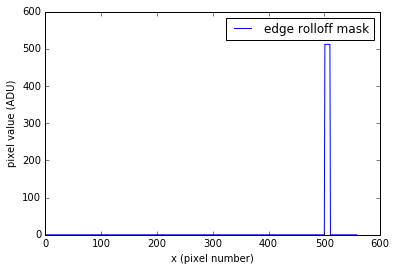

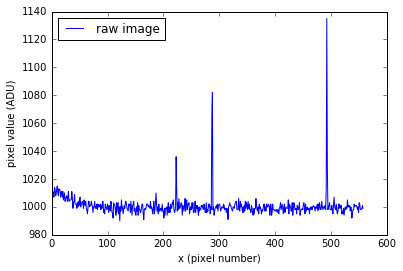

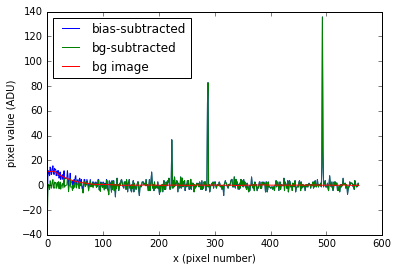

In [11]:
# The main data abstraction in the eotest code is the MaskedCCD class.
# It handles amplifier/pixel geometry and masks automatically.
#
# Various functions and task generate mask files, the names of which
# can be passed via a tuple in the constructor.
mask_file = '%s_edge_rolloff_mask.fits' % sensor_id
edge_rolloff_mask = sensorTest.rolloff_mask(image_file, mask_file)
ccd = sensorTest.MaskedCCD(image_file, mask_files=(mask_file,))
ccd.setAllMasks()     # This enables all of the mask bits.

mask = afw_image.ImageI(mask_file, hdu)
plot_serial(mask, row, label='edge rolloff mask')
plt.legend(loc=1)

amp = 1
plt.figure()
plot_serial(ccd[amp].getImage(), row, label='raw image')
plt.legend(loc=0)

plt.figure()
image_minus_bias = ccd.bias_subtracted_image(amp, fit_order=1).getImage()
plot_serial(image_minus_bias, row, label='bias-subtracted')

bg_ctrl = afw_math.BackgroundControl(bg_size, bg_size, ccd.stat_ctrl)
bg_object = afw_math.makeBackground(image_minus_bias, bg_ctrl)
bg_image = bg_object.getImageF('LINEAR')

#image = image_minus_bias.Factory(image_minus_bias, deep=True)    # v14_0
image = image_minus_bias.Factory(image_minus_bias)               # v12_0
image -= bg_image

plot_serial(image, row, label='bg-subtracted')
plot_serial(bg_image, row, label='bg image')
plt.legend(loc=0)

In [12]:
# Various bounding boxes are computed from the FITS header data.
print(ccd.amp_geom.imaging)
print(ccd.amp_geom.serial_overscan)
print(ccd.amp_geom.parallel_overscan)

Box2I((0, 0), (508, 1999))
Box2I((509, 0), (558, 2009))
Box2I((0, 2000), (509, 2009))


In [13]:
# The Fe55Task will fit 2D Gaussians to the raw footprints, thereby estimating both the flux
# and PSF sigma for each charge cluster.  This can take several minutes since it computes
# gains and PSF sigmas for all 16 amplifiers.
task = sensorTest.Fe55Task()
mask_files = ()
task.run(sensor_id, (image_file,), mask_files)

/nfs/farm/g/lsst/u1/software/redhat6-x86_64-64bit-gcc44/DMstack/v12_0/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


{1: 2.6600574881328454,
 2: 2.6556059792428215,
 3: 2.6555889242071227,
 4: 2.6727043692917429,
 5: 2.6593248039503181,
 6: 2.6751874937009861,
 7: 2.6766820752966693,
 8: 2.6594750687834208,
 9: 2.7200704110344316,
 10: 2.7777211839994083,
 11: 2.7857204758377545,
 12: 2.7867135381553503,
 13: 2.8472023582959043,
 14: 2.7726940297344407,
 15: 2.7773994486335902,
 16: 2.7282575370651352}